## Starfysh tutorial

#### Azizi Lab

Siyu He, Yinuo Jin

06-12-2022

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context

## load starfysh

In [3]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      dataloader,
                      post_analysis
                      )

## load data and gene signature

In [4]:
# set the data folder
if IN_COLAB:
    data_folder = '/content/drive/MyDrive/SpatialModelProject/data'
else:
    data_folder = 'data/'

In [5]:
## load data and gene signature
sample_id='MBC_2A' # , CID444971, CID4465, CID4290, CID4535, 1142243F, 1160920F
sig_file_name = 'bc_signatures_version_0201.csv'

adata_sample = utils.load_adata(data_folder,sample_id,n_genes=2000)
gene_sig = pd.read_csv(os.path.join(data_folder,sig_file_name))

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Preprocessing1: delete the mt and rp


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Preprocessing2: Normalize


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


In [6]:
gene_sig

,T cells CD4 CCR7,T cells CD4 IL7R,T cells CD4 Tfh CXCL13,T regs FOXP3,B cells memory,B cells naive,NK,Macrophage M1,Macrophage M2,Endothelial,...,cDC,pDC,Terminal exhaustion,Precursor exhaustion,CAFs MSC iCAF-like,CAFs myCAF-like,PVL differentiated,PVL immature,Normal epithelial,Plasmablasts
0,CCR7,IL7R,CXCL13,TNFRSF4,MS4A1,CD79A,GNLY,C1QB,CXCL10,ACKR1,...,CD80,IL3RA,CD3G,TCF7,APOD,COL1A1,ACTA2,CCL19,KRT14,IGKV3-15
1,LTB,ANXA1,NMB,LTB,CD79A,TCL1A,XCL1,C1QA,C1QB,FABP4,...,CD86,LILRA4,FASLG,MS4A4A,DCN,COL1A2,TAGLN,RGS5,KRT17,IGHG1
2,IL7R,CXCR4,NR3C1,IL32,CD83,MS4A1,XCL2,C1QC,C1QC,PLVAP,...,CCR7,CD123,ID2,TNFSF8,PTGDS,COL3A1,MYL9,IGFBP7,LTF,IGKV1-5
3,SARAF,KLRB1,DUSP4,BATF,CD37,CD37,AREG,CCL3,CXCL9,RAMP2,...,CD1A,TCF4,LAG3,CXCL10,CFD,LUM,TPM2,NDUFA4L2,KRT15,IGKV3-20
4,SELL,TNFAIP3,TNFRSF18,FOXP3,BANK1,CD74,KLRD1,CCL3L3,C1QA,VWF,...,CD1C,IRF7,RGS1,EEF1B2,LUM,SFRP2,NDUFA4L2,CCL2,PTN,IGKV3-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
gene_sig = utils.filter_gene_sig(gene_sig,adata_sample.to_df())

## get library size

In [8]:
if data_folder =='simu_data':
    map_info = utils.get_simu_map_info(umap_df)
else:
    #adata_image, adata_image_h, adata_image_e,map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)
    adata_image,map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)

log_lib = np.log((adata_sample.to_df()).sum(axis=1))
win_loglib = utils.get_windowed_library(adata_sample,
                                  map_info,
                                  log_lib,
                                  window_size=3
                                 )

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## plot log lib

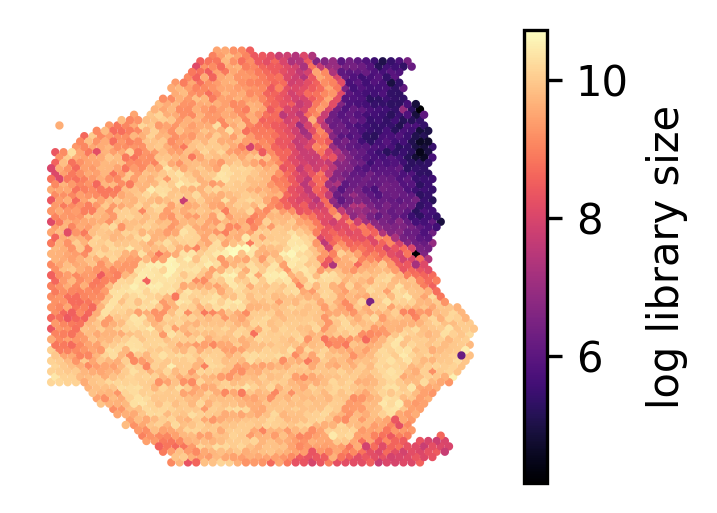

In [9]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 log_lib,
                 label='log library size'
                )

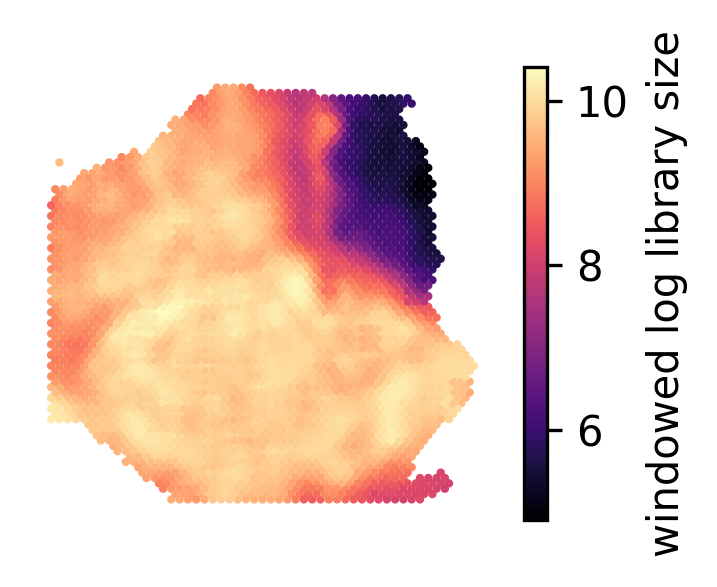

In [10]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 win_loglib,
                 label='windowed log library size'
                )

## plot raw gene expression

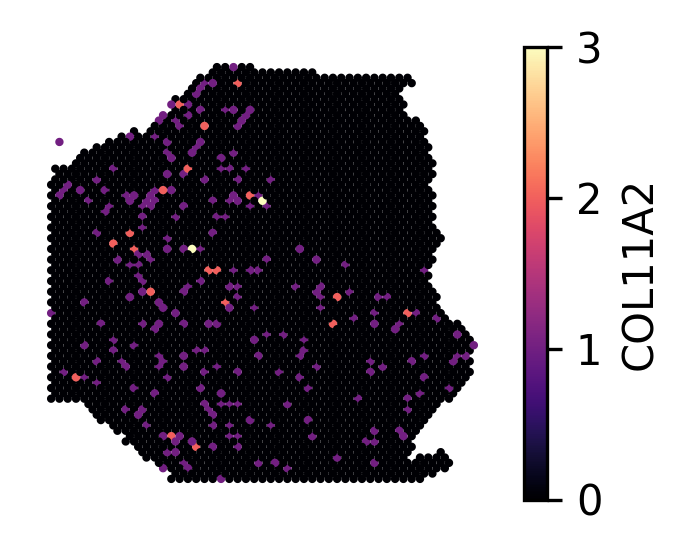

In [11]:
plot_gene_name = 'COL11A2'
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 adata_sample.to_df().loc[:,plot_gene_name],
                 label=plot_gene_name
                )

## prepare input (prior, anchor spots and data)

In [12]:
adata_sample = utils.get_adata_wsig(adata_sample, gene_sig)
sig_mean = utils.get_sig_mean(adata_sample, gene_sig, log_lib)

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (658,)
after filter out some genes in the signature not in the var_names ... (626,)
after filter out some genes not highly expressed in the signature ... (626,)
combine the varibale and siganture, the total unique gene number is ... 2509


In [13]:
pure_spots, pure_dict, pure_idx = utils.get_anchor_spots(adata_sample,
                                               sig_mean,
                                               v_low = 10,#10, 
                                               v_high = 95,#99,
                                               n_anchor = 60#60
                                              )

/content/drive/MyDrive/SpatialModelProject/model_test_colab/starfysh/utils.py:243: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pure_spots = np.transpose(sig_mean.loc[highq_spots,:].index[(-np.array(sig_mean.loc[highq_spots,:])).argsort(axis=0)[:n_anchor,:]])


## plot anchor spots

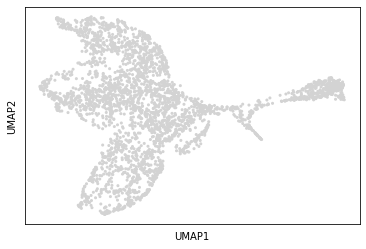

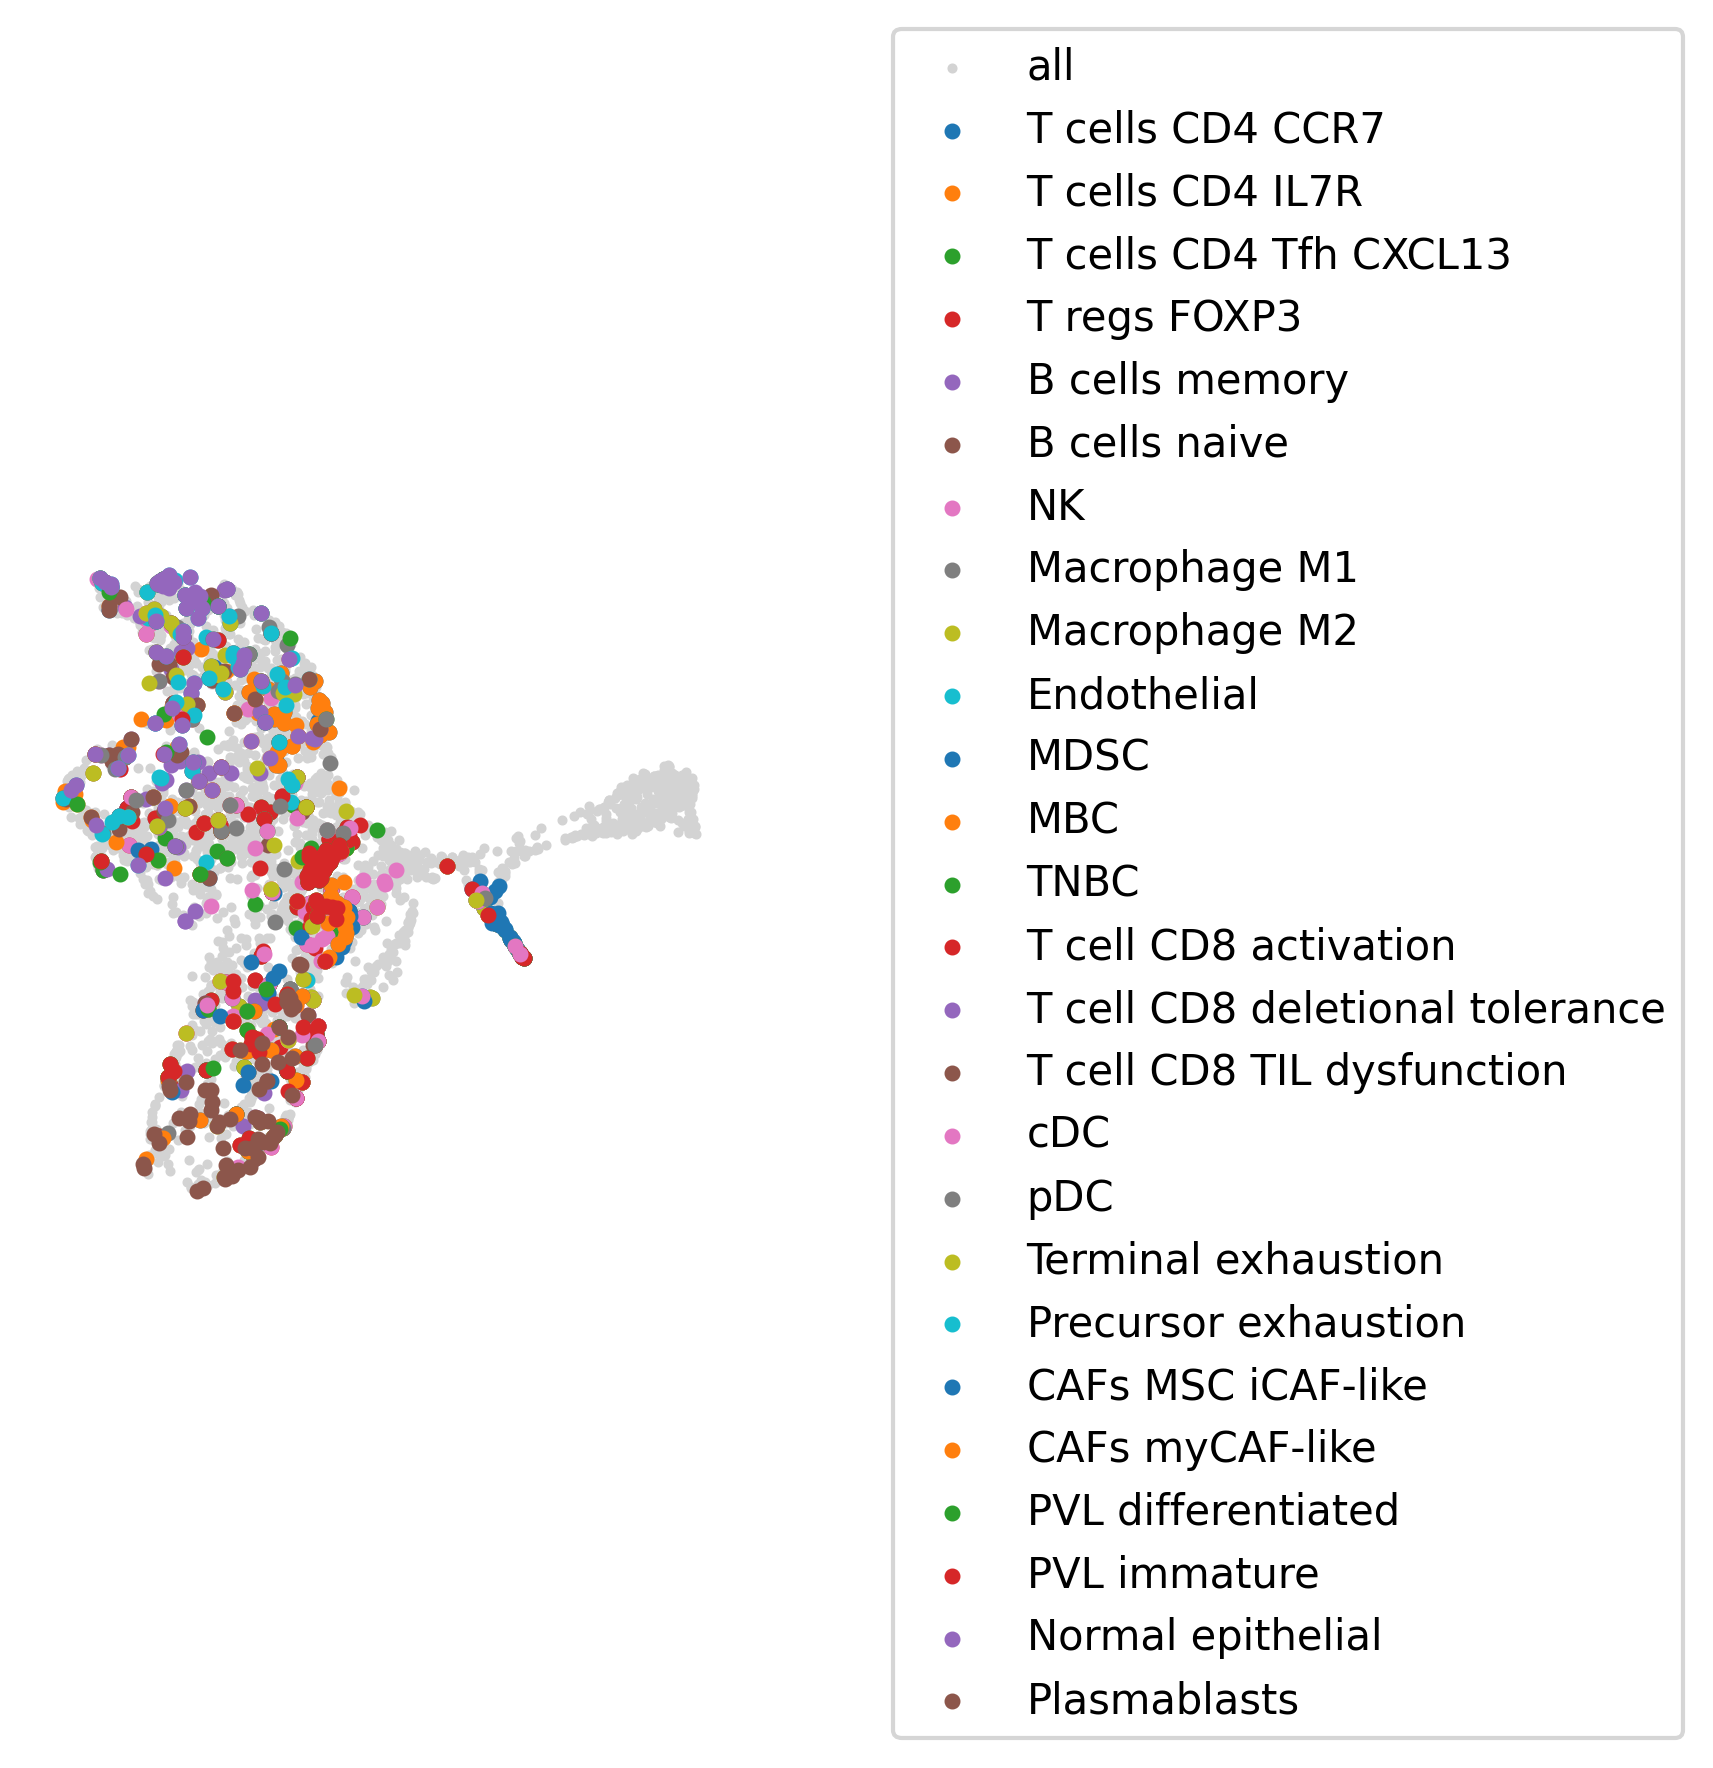

In [14]:
umap_df = utils.get_umap(adata_sample)
plot_utils.plot_anchor_spots(umap_df,pure_spots,sig_mean,bbox_x=2.4)

## Run starfysh

In [15]:
alpha_min = 0
for col_idx in np.array(sig_mean.columns):
    if (1/(sig_mean.loc[pure_dict[col_idx],:]/sig_mean.loc[pure_dict[col_idx],:].sum())[col_idx]).max()>alpha_min:
        alpha_min = (1/(sig_mean.loc[pure_dict[col_idx],:]/sig_mean.loc[pure_dict[col_idx],:].sum())[col_idx]).max()


model = starfysh.AVAE(
            adata = adata_sample,
            gene_sig = gene_sig,
            alpha_min = alpha_min,
            win_loglib = win_loglib,
          )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

trainset = dataloader.VisiumDataset(adata=adata_sample, 
                                    gene_sig_exp_m=sig_mean,
                                    adata_pure = pure_idx,
                                    library_n = win_loglib
                                    )

trainloader = DataLoader(trainset, 
                         batch_size=32, 
                         shuffle=True)

epochs= 30
train_loss = []
corr_list_all = []
for epoch in range(epochs):
    (train_epoch_loss, 
     train_reconst, 
     train_z, 
     train_c, 
     train_n, 
     corr_list) = starfysh.train(model, 
                                 trainloader, 
                                 trainset, 
                                 device, 
                                 optimizer)
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    corr_list_all.append(corr_list)
    if (epoch+1) % 1 == 0:
            print ("Epoch[{}/{}], train_loss: {:.4f}, train_reconst: {:.4f}, train_z: {:.4f},train_c: {:.4f},train_n: {:.4f}".format(epoch+1, epochs, train_epoch_loss, train_reconst, train_z, train_c, train_n))  
print('finish lower training rate')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class 'starfysh.starfysh.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


Epoch[1/30], train_loss: 7415.0775, train_reconst: 1857.4990, train_z: 23.6733,train_c: 5359.9784,train_n: 173.9269
Epoch[2/30], train_loss: 4583.8334, train_reconst: 1508.4323, train_z: 21.4840,train_c: 2926.7440,train_n: 127.1731
Epoch[3/30], train_loss: 4163.1317, train_reconst: 1461.7631, train_z: 19.0316,train_c: 2571.7726,train_n: 110.5644
Epoch[4/30], train_loss: 3852.5323, train_reconst: 1443.4444, train_z: 19.0538,train_c: 2293.8482,train_n: 96.1860
Epoch[5/30], train_loss: 3722.8824, train_reconst: 1432.3843, train_z: 19.6014,train_c: 2187.5382,train_n: 83.3586
Epoch[6/30], train_loss: 3568.2750, train_reconst: 1418.5120, train_z: 20.6689,train_c: 2058.8766,train_n: 70.2175
Epoch[7/30], train_loss: 3472.8468, train_reconst: 1418.8129, train_z: 21.1865,train_c: 1972.3574,train_n: 60.4899
Epoch[8/30], train_loss: 3455.8753, train_reconst: 1411.0345, train_z: 21.4607,train_c: 1970.2472,train_n: 53.1329
Epoch[9/30], train_loss: 3399.1103, train_reconst: 1397.0221, train_z: 21.849

## Basic downstream analysis

In [16]:
lib_low=torch.exp(torch.Tensor([5.0])).to(device)
inference_outputs, generative_outputs, px = starfysh.model_eval(model,adata_sample, sig_mean, device,log_lib,lib_low)
u = post_analysis.get_z_umap(inference_outputs)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

/content/drive/MyDrive/SpatialModelProject/model_test_colab/starfysh/starfysh.py:472: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  library_i = torch.Tensor(library_i[:,None])
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class 'starfysh.starfysh.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


#### 1. gene sig mean vs. inferred prop

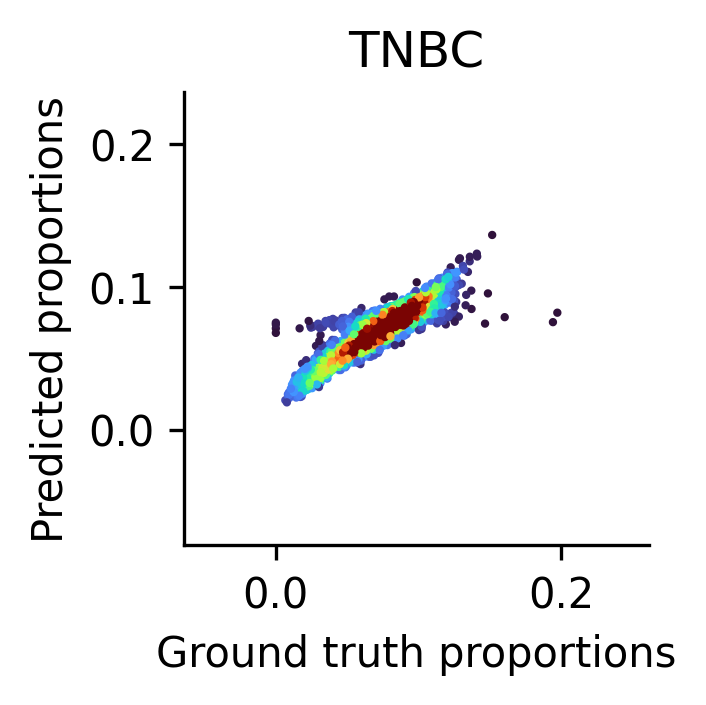

In [17]:
sig_mean_n_df = pd.DataFrame(np.array(sig_mean)/(np.sum(np.array(sig_mean),axis=1,keepdims=True)+1e-5),
                                 columns=sig_mean.columns,
                                 index = sig_mean.index
                                )
post_analysis.pred_prop_scatter(inference_outputs,
                                    sig_mean_n_df,
                                    idx=12)

#### 2. inferred density

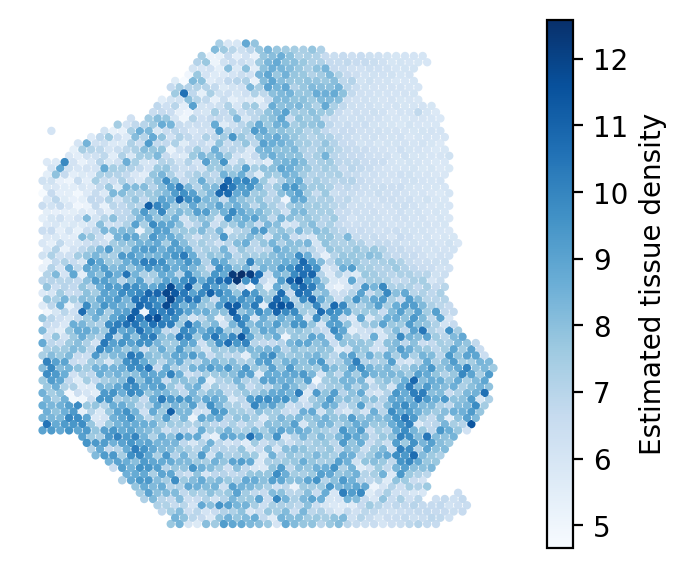

In [18]:
plot_utils.pl_spatial_inf_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='ql_m',
                   idx=0,
                   plt_title='',
                   label='Estimated tissue density',
                   s=4,
                   #vmax=1
                   )

#### 3. inferred prop. on umap (adjust idx number for different cell types)

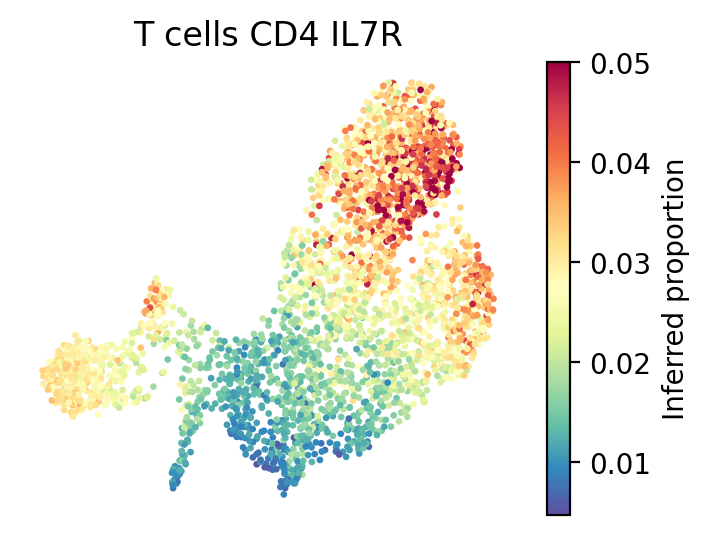

In [19]:
idx=1
plot_utils.pl_umap_feature(adata_sample,
                   u,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),#/np.sum(np.array(sig_mean),axis=1,keepdims=True),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=2,
                   vmax=0.05
                   )

#### 4. inferred prop. on spatial loc (adjust idx number for different cell types)

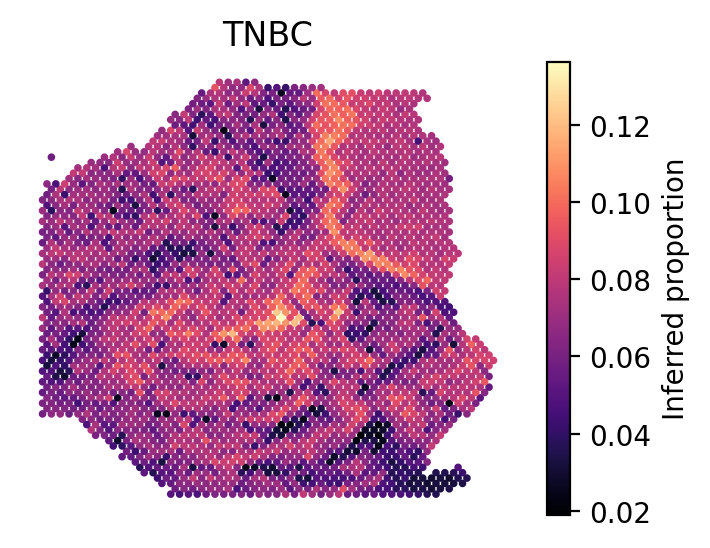

In [20]:
idx=12
plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=3,
                   #vmax=2
                   )

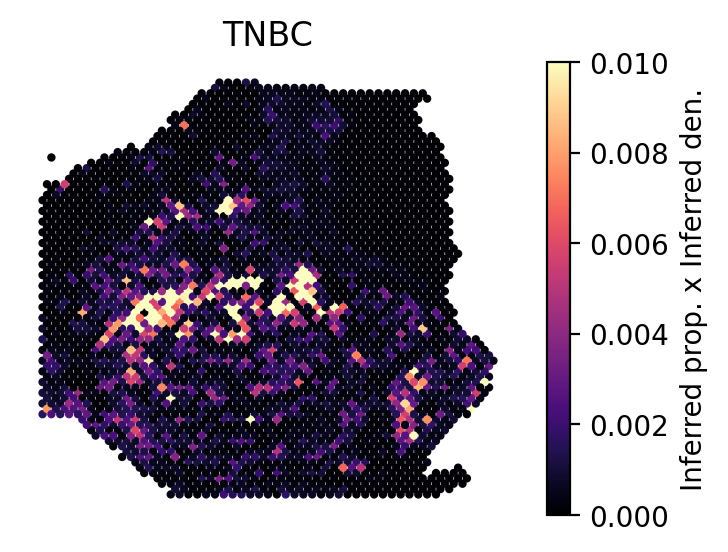

In [21]:
idx=12
ql_m_norm = np.exp(inference_outputs['ql_m'].detach().cpu().numpy())
ql_m_norm = (ql_m_norm-ql_m_norm.min())/(ql_m_norm.max()-ql_m_norm.min())
                   
plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy())*ql_m_norm,
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred prop. x Inferred den.',
                   s=4,
                   vmax=0.01
                   )

In [22]:
model.alpha

Parameter containing:
tensor([48.5623], requires_grad=True)

In [23]:
dist = {
        'px_rate': generative_outputs['px_rate'].detach().cpu().numpy().tolist(),
        'px_r': generative_outputs['px_r'].detach().cpu().numpy().tolist(),
        'pc_p': generative_outputs['pc_p'].detach().cpu().numpy().tolist(),

        'qc_m': inference_outputs['qc_m'].detach().cpu().numpy().tolist(),
        'qc': inference_outputs['qc'].detach().cpu().numpy().tolist(),
        'qz_m': inference_outputs['qz_m'].detach().cpu().numpy().tolist(),
        'qz_m_ct': inference_outputs['qz_m_ct'].detach().cpu().numpy().tolist(),
        'qz_logv': inference_outputs['qz_logv'].detach().cpu().numpy().tolist(),
        'qz_logv_ct': inference_outputs['qz_logv_ct'].detach().cpu().numpy().tolist(),
        'qz': inference_outputs['qz'].detach().cpu().numpy().tolist(),
        'ql_m': inference_outputs['ql_m'].detach().cpu().numpy().tolist(),
        'ql_logv': inference_outputs['ql_logv'].detach().cpu().numpy().tolist(),
        'ql': inference_outputs['ql'].detach().cpu().numpy().tolist(),
}


import json
with open('/content/drive/MyDrive/SpatialModelProject/model_test_colab/results/02_factor/'+sample_id+'_factor.json', 'w') as fp:
#with open('results/02_factor/'+sample_id+'_factor.json', 'w') as fp:

    json.dump(dist, fp)